## **IMPORT**

In [1]:
from ChessCore import *
from ChessEngine import *
from numba import cuda, types
import time
import math

## **TESTS**

### TEST FUNCTION ON THE CPU

*Input:*
- `fen`: FEN string representing the current state of the game
- `king_moves_only`: Whether you want to see all possible moves or only the king's moves (Optional, default: `False`)
- `plot_moves`: Whether you want to plot the board after each of the possible moves (Optional, default: `False`)

*Output:* 
- Plots the board and all querried moves
- Measures execution time

In [2]:
def chess_move_generation_test_cpu(fen: str = None, king_moves_only: bool = False, plot_moves: bool = False):
    game = ChessGame() if fen is None else ChessGame(fen)

    start = time.time()
    moves = game.generate_all_moves()
    end = time.time()

    print(f'Execution time: {end - start} s')

    if king_moves_only:
        king_position = game.get_king_position(game.side_to_move())
        if king_position >= 0:
            moves = [move for move in moves if move.start_position() == king_position]

    if plot_moves:
        num_moves = len(moves)
        if num_moves > 0:
            cols = math.ceil(math.sqrt(num_moves))
            rows = math.ceil(num_moves / cols)

            fig, axs = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))

            row, col = 0, 0

            for move in moves:
                game_copy = game.copy()
                game_copy.move(move)
                game_copy.plot(moves=[move], ax=axs[row, col] if rows > 1 else axs[col])
                col += 1
                if col >= cols:
                    col = 0
                    row += 1

            while row < rows:
                (axs[row, col] if rows > 1 else axs[col]).set_visible(False)
                col += 1
                if col >= cols:
                    col = 0
                    row += 1
        else:
            print('No move found')

    else:
        game.plot(moves=moves)

### TEST FUNCTION ON THE GPU

*Input:*
- `fen`: FEN string representing the current state of the game
- `king_moves_only`: Whether you want to see all possible moves or only the king's moves (Optional, default: `False`)
- `plot_moves`: Whether you want to plot the board after each of the possible moves (Optional, default: `False`)

*Output:* 
- Plots the board and all querried moves
- Measures execution time

In [3]:
@cuda.jit
def generate_moves_kernel(board, side, castle_WK, castle_WQ, castle_BK, castle_BQ, en_passant_target, halfmoves, out_moves, out_count):
    count = generate_all_moves_device(board, side, castle_WK, castle_WQ, castle_BK, castle_BQ, en_passant_target, halfmoves, out_moves)
    out_count[0] = count

out_moves = np.empty(256, dtype=np.int32)
out_count = np.empty(1, dtype=np.int32)
generate_moves_kernel[1, 1](np.zeros(64, dtype=np.int32), True, True, True, True, True, -1, 0, out_moves, out_count)

def decode_move(side: bool, move: int):
    start_position = (move >>  0) & 0xFF
    end_position   = (move >>  8) & 0xFF
    promote_to     = (move >> 16) & 0x07
    en_passant     = (move >> 19) & 0x01 != 0

    if en_passant:
        en_passant_target = end_position
    else:
        en_passant_target = None

    if promote_to > 0:
        promote_to += 2
        promote_to |= 0x08 if side else 0x00
    else:
        promote_to = None

    return Move(start_position, end_position, promote_to=promote_to, en_passant_target=en_passant_target)

def chess_move_generation_test_gpu(fen: str = None, king_moves_only: bool = False, plot_moves: bool = False):
    game = ChessGame() if fen is None else ChessGame(fen)

    start = time.time()
    d_board     = cuda.to_device(np.array(game.get_board(), dtype=np.int32))
    d_out_moves = cuda.device_array(256, dtype=np.int32)
    d_out_count = cuda.device_array(1, dtype=np.int32)
    generate_moves_kernel[1, 1](d_board, game.side_to_move(), game.m_castle_WK, game.m_castle_WQ, game.m_castle_BK, game.m_castle_BQ, -1 if game.m_en_passant_target is None else game.m_en_passant_target, game.get_halfmove(), d_out_moves, d_out_count)
    out_moves = d_out_moves.copy_to_host()
    out_count = d_out_count.copy_to_host()[0]
    moves = [decode_move(game.side_to_move(), move) for move in out_moves[:out_count]]
    end = time.time()

    print(f'Execution time: {end - start} s')

    if king_moves_only:
        king_position = game.get_king_position(game.side_to_move())
        if king_position >= 0:
            moves = [move for move in moves if move.start_position() == king_position]

    if plot_moves:
        num_moves = len(moves)
        if num_moves > 0:
            cols = math.ceil(math.sqrt(num_moves))
            rows = math.ceil(num_moves / cols)

            fig, axs = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))

            row, col = 0, 0

            for move in moves:
                game_copy = game.copy()
                game_copy.move(move)
                game_copy.plot(moves=[move], ax=axs[row, col] if rows > 1 else axs[col])
                col += 1
                if col >= cols:
                    col = 0
                    row += 1

            while row < rows:
                (axs[row, col] if rows > 1 else axs[col]).set_visible(False)
                col += 1
                if col >= cols:
                    col = 0
                    row += 1
        else:
            print('No move found')

    else:
        game.plot(moves=moves)

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


### TEST 1: Default layout

- Default pieces placement
- White moves
- Castling rights:
    - White: king's side, queen's side
    - Black: king's side, queen's side

Execution time: 0.0 s


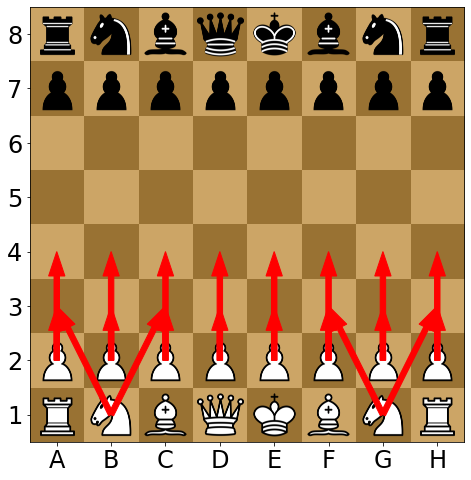

In [4]:
chess_move_generation_test_cpu()

Execution time: 0.001001596450805664 s


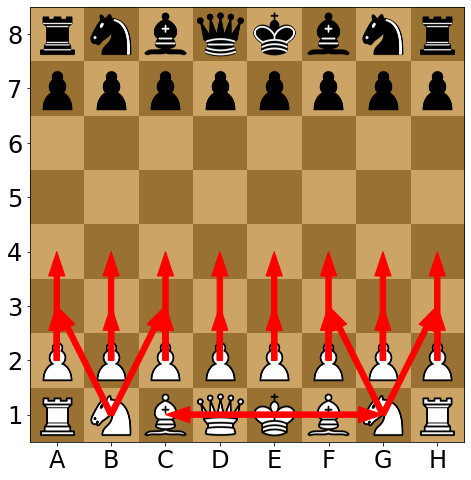

In [5]:
chess_move_generation_test_gpu()

### TEST 2: Castling

- White king and rooks didn't moved, black king moved
- White moves
- Castling rights:
    - White: king's side, queen's side
    - Black: none

*Note: Only king's moves are shown here to prevent confusion*

Execution time: 0.0 s


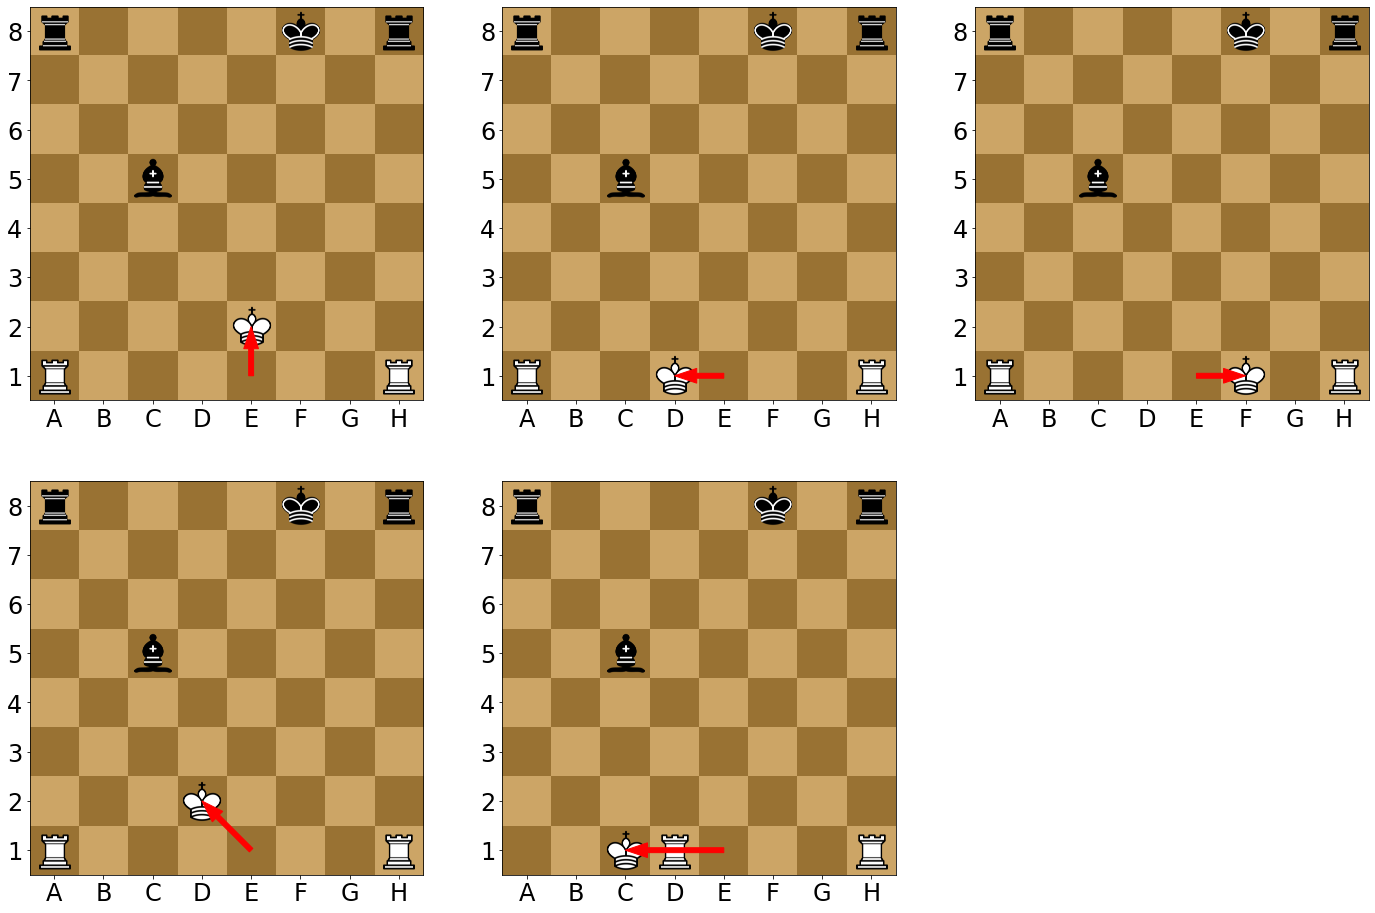

In [6]:
chess_move_generation_test_cpu('r4k1r/8/8/2b5/8/8/8/R3K2R w KQ - 0 42', king_moves_only=True, plot_moves=True)

Execution time: 0.0020084381103515625 s


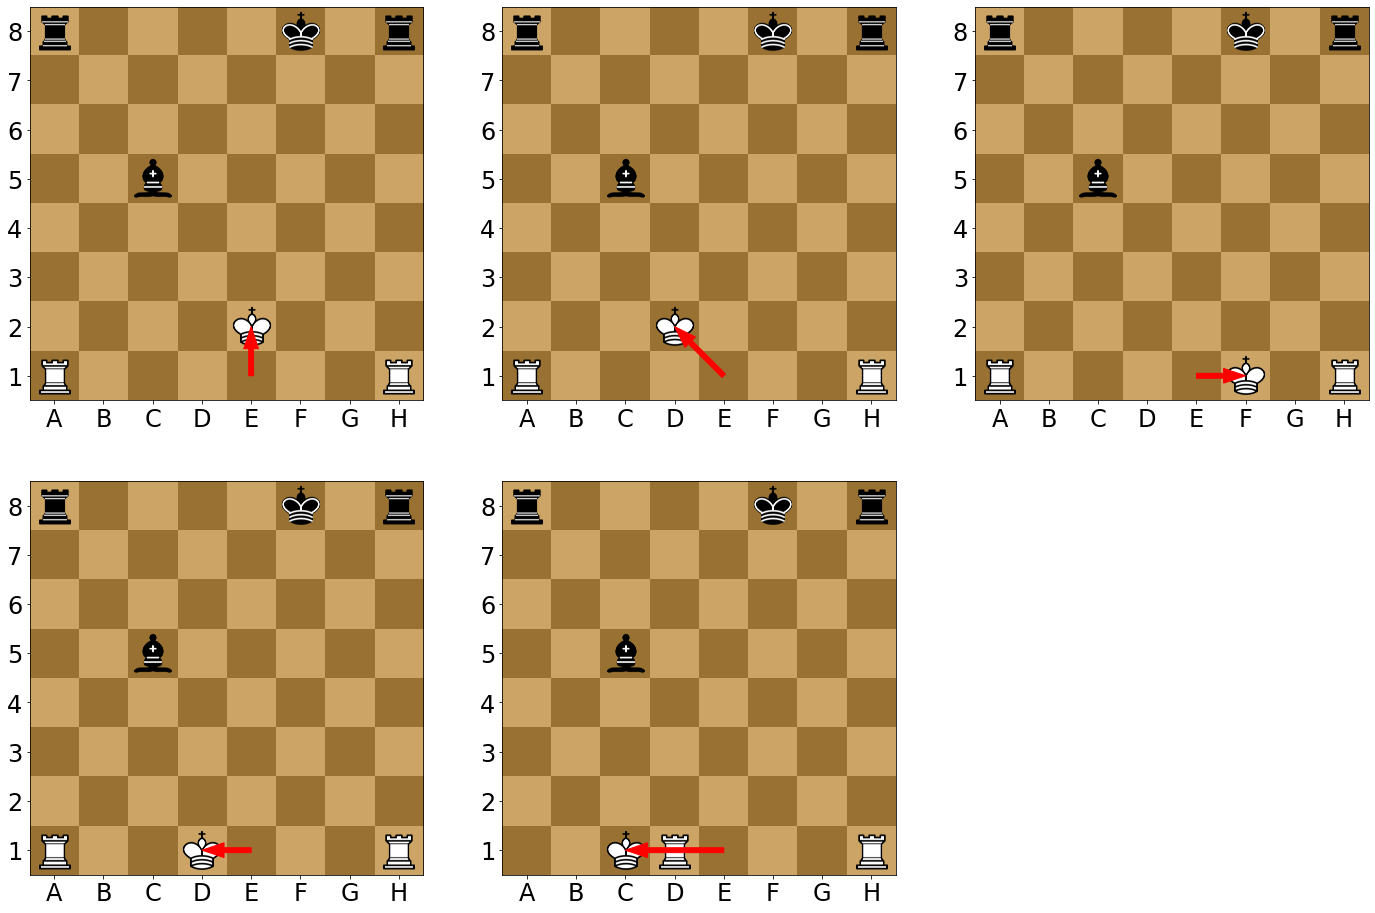

In [7]:
chess_move_generation_test_gpu('r4k1r/8/8/2b5/8/8/8/R3K2R w KQ - 0 42', king_moves_only=True, plot_moves=True)

### TEST 3: Pinned

- Black pawn is pinned by white queen and shouldn't be able to move
- Black moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0 s


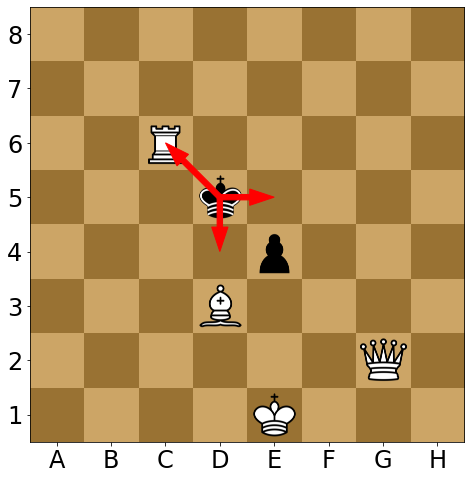

In [8]:
chess_move_generation_test_cpu('8/8/2R5/3k4/4p3/3B4/6Q1/4K3 b - - 0 1')

Execution time: 0.0010149478912353516 s


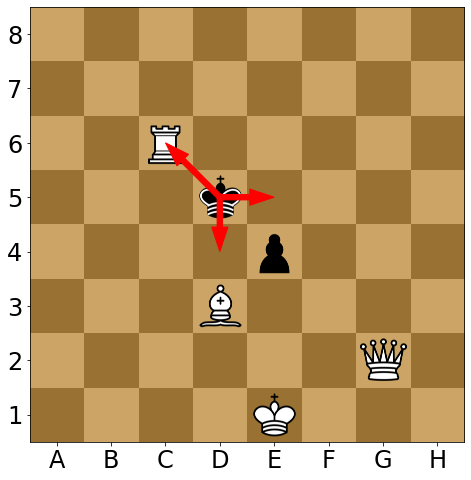

In [9]:
chess_move_generation_test_gpu('8/8/2R5/3k4/4p3/3B4/6Q1/4K3 b - - 0 1')

### TEST 4: Checked

- Black king is currently in check, and can either move away, block with the knight or capture the rook
- Black moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0009975433349609375 s


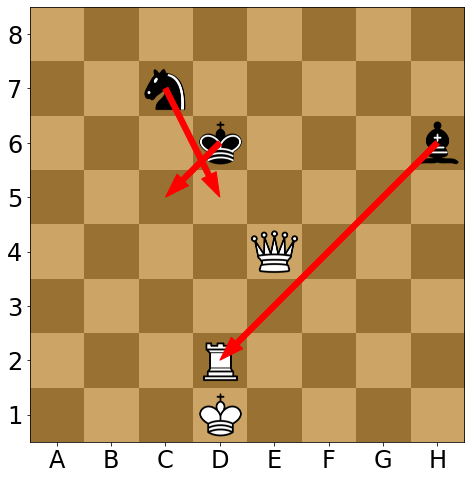

In [10]:
chess_move_generation_test_cpu('8/2n5/3k3b/8/4Q3/8/3R4/3K4 b - - 0 1')

Execution time: 0.0019981861114501953 s


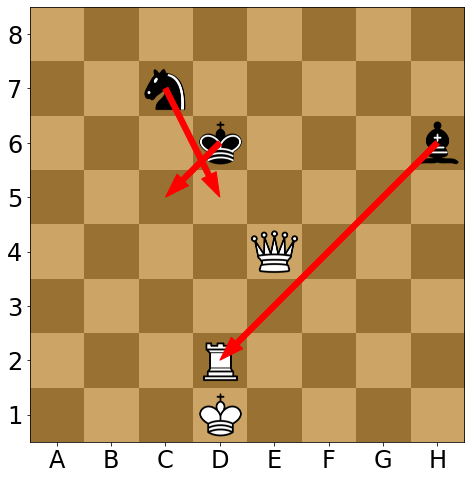

In [11]:
chess_move_generation_test_gpu('8/2n5/3k3b/8/4Q3/8/3R4/3K4 b - - 0 1')

### TEST 5: En passant

- White pawn has just moved up 2 spaces, and therefore can be captured via En passant
- Black moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0 s


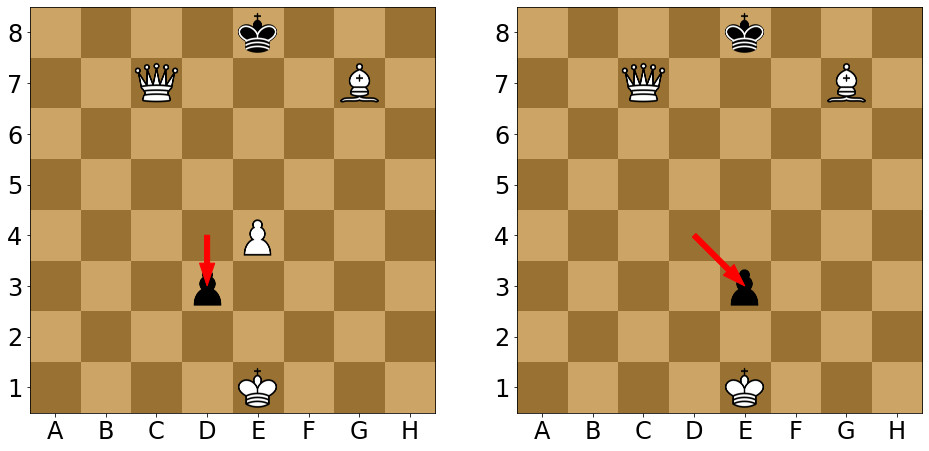

In [12]:
chess_move_generation_test_cpu('4k3/2Q3B1/8/8/3pP3/8/8/4K3 b - e3 0 1', plot_moves=True)

Execution time: 0.0009987354278564453 s


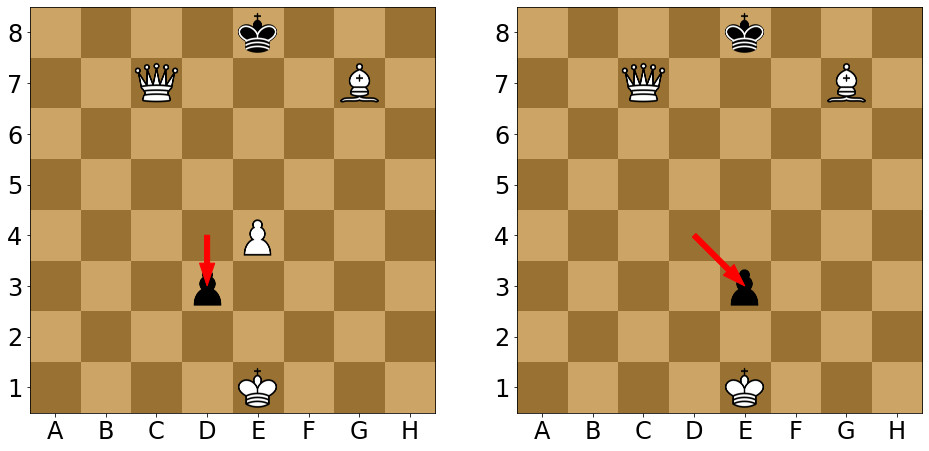

In [13]:
chess_move_generation_test_gpu('4k3/2Q3B1/8/8/3pP3/8/8/4K3 b - e3 0 1', plot_moves=True)

### TEST 6: Pawn's promotion

- White pawn is about to reach rank 8 and promote
- White moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0 s


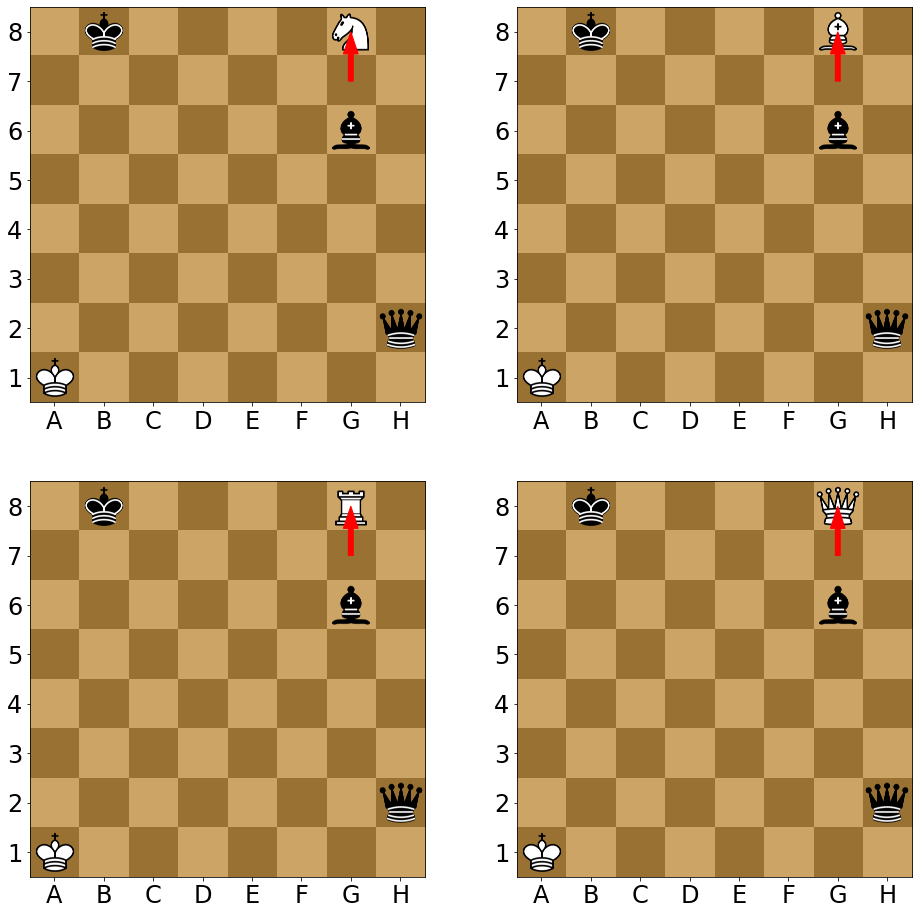

In [14]:
chess_move_generation_test_cpu('1k6/6P1/6b1/8/8/8/7q/K7 w - - 0 1', plot_moves=True)

Execution time: 0.0011386871337890625 s


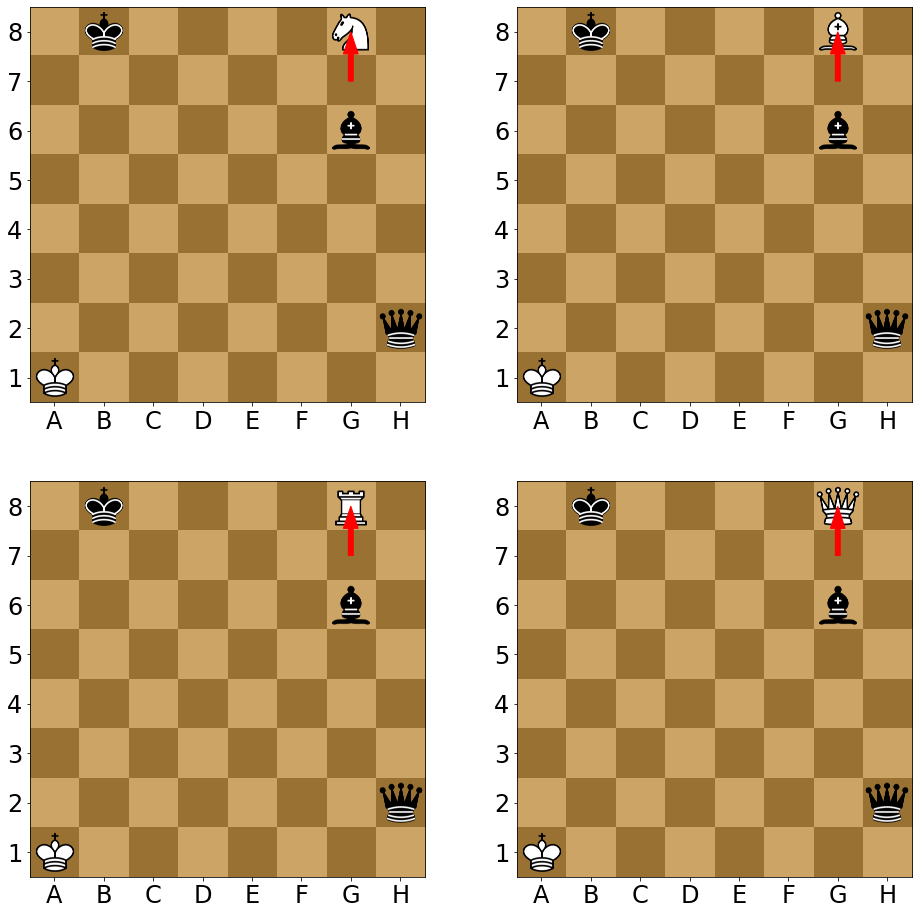

In [15]:
chess_move_generation_test_gpu('1k6/6P1/6b1/8/8/8/7q/K7 w - - 0 1', plot_moves=True)

### TEST 7: En passant special case

- Rare special case where if white captures via En passant it would create a check
- White moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0 s


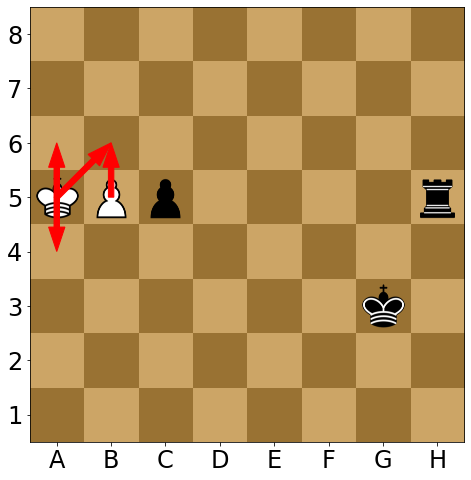

In [16]:
chess_move_generation_test_cpu('8/8/8/KPp4r/8/6k1/8/8 w - c6 0 1')

Execution time: 0.0020546913146972656 s


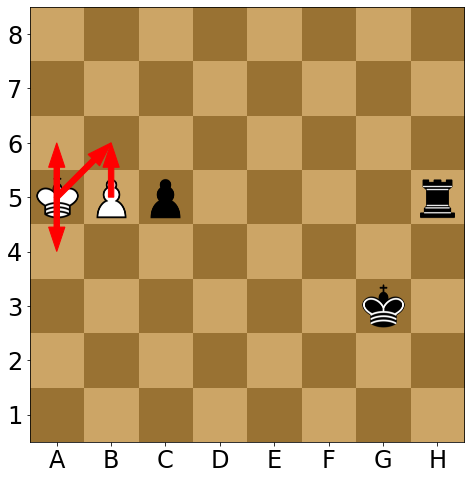

In [17]:
chess_move_generation_test_gpu('8/8/8/KPp4r/8/6k1/8/8 w - c6 0 1')